In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [14]:
check = pd.read_csv('../../data_generation/data/dirt-2/train_data.csv')

In [8]:
# Custom Dataset class
class TORCSDataset(Dataset):
    def __init__(self, csv_file, sensor_cols, continuous_cols, discrete_cols):
        self.data = pd.read_csv(csv_file)
        self.sensor_cols = [col for col in self.data.columns if col in sensor_cols]
        # self.sensor_cols = sensor_cols
        self.continuous_cols = [col for col in self.data.columns if col in continuous_cols]
        # self.continuous_cols = continuous_cols
        self.discrete_cols = [col for col in self.data.columns if col in discrete_cols]
        # self.discrete_cols = discrete_cols

        self.features = torch.tensor(self.data[self.sensor_cols].values, dtype=torch.float32)
        self.steering_labels = torch.tensor(self.data['Steering'].values, dtype=torch.float32).view(-1, 1)
        self.accel_labels = torch.tensor(self.data['Acceleration'].values, dtype=torch.long)
        self.brake_labels = torch.tensor(self.data['Braking'].values, dtype=torch.long)
        self.gear_labels = torch.tensor(self.data['Gear'].values, dtype=torch.long)
        self.clutch_labels = torch.tensor(self.data['Clutch'].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.features[idx],
            self.steering_labels[idx],
            self.accel_labels[idx],
            self.brake_labels[idx],
            self.gear_labels[idx],
            self.clutch_labels[idx]
        )

In [9]:
# Neural Network Model
class TORCSNet(nn.Module):
    def __init__(self, input_size, num_accel_classes, num_brake_classes, num_gear_classes, num_clutch_classes=2):
        super(TORCSNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.steering_head = nn.Linear(128, 1)  # Steering (continuous, [-1, 1])
        self.accel_head = nn.Linear(128, num_accel_classes)  # Acceleration (discrete)
        self.brake_head = nn.Linear(128, num_brake_classes)  # Braking (discrete)
        self.gear_head = nn.Linear(128, num_gear_classes)  # Gear (discrete)
        self.clutch_head = nn.Linear(128, num_clutch_classes)  # Clutch (discrete)
        
    def forward(self, x):
        shared = self.shared(x)
        steering_out = torch.tanh(self.steering_head(shared))  # [-1, 1]
        accel_out = self.accel_head(shared)  # Logits
        brake_out = self.brake_head(shared)  # Logits
        gear_out = self.gear_head(shared)  # Logits
        clutch_out = self.clutch_head(shared)  # Logits
        return steering_out, accel_out, brake_out, gear_out, clutch_out

In [10]:
# Training function
def train_model(model, train_loader, val_loader, criterion_steering, criterion_accel, criterion_brake, criterion_gear, criterion_clutch, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        accel_correct = 0
        brake_correct = 0
        gear_correct = 0
        clutch_correct = 0
        total = 0
        
        for features, steering_labels, accel_labels, brake_labels, gear_labels, clutch_labels in train_loader:
            features = features.to(device)
            steering_labels = steering_labels.to(device)
            accel_labels, brake_labels = accel_labels.to(device), brake_labels.to(device)
            gear_labels, clutch_labels = gear_labels.to(device), clutch_labels.to(device)
            
            optimizer.zero_grad()
            steering_out, accel_out, brake_out, gear_out, clutch_out = model(features)
            
            loss_steering = criterion_steering(steering_out, steering_labels)
            loss_accel = criterion_accel(accel_out, accel_labels)
            loss_brake = criterion_brake(brake_out, brake_labels)
            loss_gear = criterion_gear(gear_out, gear_labels)
            loss_clutch = criterion_clutch(clutch_out, clutch_labels)
            loss = loss_steering + loss_accel + loss_brake + loss_gear + loss_clutch
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * features.size(0)
            accel_correct += (torch.argmax(accel_out, dim=1) == accel_labels).sum().item()
            brake_correct += (torch.argmax(brake_out, dim=1) == brake_labels).sum().item()
            gear_correct += (torch.argmax(gear_out, dim=1) == gear_labels).sum().item()
            clutch_correct += (torch.argmax(clutch_out, dim=1) == clutch_labels).sum().item()
            total += gear_labels.size(0)
        
        train_loss /= len(train_loader.dataset)
        accel_acc = accel_correct / total
        brake_acc = brake_correct / total
        gear_acc = gear_correct / total
        clutch_acc = clutch_correct / total
        
        # Validation
        model.eval()
        val_loss = 0.0
        accel_correct = 0
        brake_correct = 0
        gear_correct = 0
        clutch_correct = 0
        total = 0
        
        with torch.no_grad():
            for features, steering_labels, accel_labels, brake_labels, gear_labels, clutch_labels in val_loader:
                features = features.to(device)
                steering_labels = steering_labels.to(device)
                accel_labels, brake_labels = accel_labels.to(device), brake_labels.to(device)
                gear_labels, clutch_labels = gear_labels.to(device), clutch_labels.to(device)
                
                steering_out, accel_out, brake_out, gear_out, clutch_out = model(features)
                
                loss_steering = criterion_steering(steering_out, steering_labels)
                loss_accel = criterion_accel(accel_out, accel_labels)
                loss_brake = criterion_brake(brake_out, brake_labels)
                loss_gear = criterion_gear(gear_out, gear_labels)
                loss_clutch = criterion_clutch(clutch_out, clutch_labels)
                loss = loss_steering + loss_accel + loss_brake + loss_gear + loss_clutch
                
                val_loss += loss.item() * features.size(0)
                accel_correct += (torch.argmax(accel_out, dim=1) == accel_labels).sum().item()
                brake_correct += (torch.argmax(brake_out, dim=1) == brake_labels).sum().item()
                gear_correct += (torch.argmax(gear_out, dim=1) == gear_labels).sum().item()
                clutch_correct += (torch.argmax(clutch_out, dim=1) == clutch_labels).sum().item()
                total += gear_labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_accel_acc = accel_correct / total
        val_brake_acc = brake_correct / total
        val_gear_acc = gear_correct / total
        val_clutch_acc = clutch_correct / total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Accel Acc: {accel_acc:.4f}, Brake Acc: {brake_acc:.4f}, Gear Acc: {gear_acc:.4f}, Clutch Acc: {clutch_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accel Acc: {val_accel_acc:.4f}, Brake Acc: {val_brake_acc:.4f}, Gear Acc: {val_gear_acc:.4f}, Clutch Acc: {val_clutch_acc:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print("  Saved best model")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.close()
    
    return train_losses, val_losses


In [11]:
# Main execution
def main():
    # Define columns (update based on preprocessing output)
    sensor_cols = [
        'Angle', 'DistanceCovered', 'LastLapTime', 'RPM' 
        'SpeedX', 'SpeedY', 'SpeedZ', 'Track_1', 'Track_2', 'Track_3', 
        'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9',
        'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 
        'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19',
        'TrackPosition', 'WheelSpinVelocity_1', 'WheelSpinVelocity_2', 
        'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'Z'
    ]  # Placeholder: Update with actual 27 sensors
    continuous_cols = ['Steering']
    discrete_cols = ['Acceleration', 'Braking', 'Gear', 'Clutch']
    
    # Load datasets
    train_dataset = TORCSDataset('../data_generation/data/dirt-2/train_data.csv', sensor_cols, continuous_cols, discrete_cols)
    val_dataset = TORCSDataset('../data_generation/data/dirt-2/val_data.csv', sensor_cols, continuous_cols, discrete_cols)
    
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    
    # Model parameters
    input_size = len(sensor_cols)
    num_accel_classes = len(train_dataset.data['Acceleration'].unique())  # Update: e.g., 2 for {0, 1}
    num_brake_classes = len(train_dataset.data['Braking'].unique())  # Update: e.g., 2 for {0, 1}
    num_gear_classes = len(train_dataset.data['Gear'].unique())  # Update: e.g., 8 for [-1, 0, 1, 2, 3, 4, 5, 6]
    num_clutch_classes = 2  # Binary {0, 1}
    
    # Initialize model
    model = TORCSNet(input_size, num_accel_classes, num_brake_classes, num_gear_classes, num_clutch_classes).to(device)
    
    # Loss functions
    criterion_steering = nn.MSELoss()
    
    # Compute class weights
    accel_counts = train_dataset.data['Acceleration'].value_counts()
    accel_class_weights = torch.tensor([1.0 / accel_counts.get(i, 1) for i in range(num_accel_classes)], dtype=torch.float32).to(device)
    brake_counts = train_dataset.data['Braking'].value_counts()
    brake_class_weights = torch.tensor([1.0 / brake_counts.get(i, 1) for i in range(num_brake_classes)], dtype=torch.float32).to(device)
    gear_counts = train_dataset.data['Gear'].value_counts()
    gear_class_weights = torch.tensor([1.0 / gear_counts.get(i, 1) for i in range(num_gear_classes)], dtype=torch.float32).to(device)
    clutch_counts = train_dataset.data['Clutch'].value_counts()
    clutch_class_weights = torch.tensor([1.0 / clutch_counts.get(i, 1) for i in [0, 1]], dtype=torch.float32).to(device)
    
    criterion_accel = nn.CrossEntropyLoss(weight=accel_class_weights)
    criterion_brake = nn.CrossEntropyLoss(weight=brake_class_weights)
    criterion_gear = nn.CrossEntropyLoss(weight=gear_class_weights)
    criterion_clutch = nn.CrossEntropyLoss(weight=clutch_class_weights)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    num_epochs = 50
    train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        criterion_steering, criterion_accel, criterion_brake, criterion_gear, criterion_clutch,
        optimizer, num_epochs, device
    )
    
    # Evaluate on test set
    test_dataset = TORCSDataset('../data_generation/data/dirt-2/test_data.csv', sensor_cols, continuous_cols, discrete_cols)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    model.load_state_dict(torch.load('./best_model.pt'))
    model.eval()
    test_loss = 0.0
    accel_correct = 0
    brake_correct = 0
    gear_correct = 0
    clutch_correct = 0
    total = 0
    
    with torch.no_grad():
        for features, steering_labels, accel_labels, brake_labels, gear_labels, clutch_labels in test_loader:
            features = features.to(device)
            steering_labels = steering_labels.to(device)
            accel_labels, brake_labels = accel_labels.to(device), brake_labels.to(device)
            gear_labels, clutch_labels = gear_labels.to(device), clutch_labels.to(device)
            
            steering_out, accel_out, brake_out, gear_out, clutch_out = model(features)
            
            loss_steering = criterion_steering(steering_out, steering_labels)
            loss_accel = criterion_accel(accel_out, accel_labels)
            loss_brake = criterion_brake(brake_out, brake_labels)
            loss_gear = criterion_gear(gear_out, gear_labels)
            loss_clutch = criterion_clutch(clutch_out, clutch_labels)
            loss = loss_steering + loss_accel + loss_brake + loss_gear + loss_clutch
            
            test_loss += loss.item() * features.size(0)
            accel_correct += (torch.argmax(accel_out, dim=1) == accel_labels).sum().item()
            brake_correct += (torch.argmax(brake_out, dim=1) == brake_labels).sum().item()
            gear_correct += (torch.argmax(gear_out, dim=1) == gear_labels).sum().item()
            clutch_correct += (torch.argmax(clutch_out, dim=1) == clutch_labels).sum().item()
            total += gear_labels.size(0)
    
    test_loss /= len(test_loader.dataset)
    accel_acc = accel_correct / total
    brake_acc = brake_correct / total
    gear_acc = gear_correct / total
    clutch_acc = clutch_correct / total
    print(f"Test Loss: {test_loss:.4f}, Accel Acc: {accel_acc:.4f}, Brake Acc: {brake_acc:.4f}, Gear Acc: {gear_acc:.4f}, Clutch Acc: {clutch_acc:.4f}")


In [12]:
if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: '../data_generation/data/dirt-2/train_data.csv'

In [ ]:
# def evaluate_model(model, dataloader, device):
#     model.eval()
    
#     all_preds_reg = []
#     all_targets_reg = []

#     all_preds_gear = []
#     all_targets_gear = []

#     all_preds_clutch = []
#     all_targets_clutch = []

#     with torch.no_grad():
#         for features, targets in dataloader:
#             features = features.to(device)
#             acceleration_true = targets['Acceleration'].to(device)
#             braking_true = targets['Braking'].to(device)
#             steering_true = targets['Steering'].to(device)
#             gear_true = targets['Gear'].to(device)
#             clutch_true = targets['Clutch'].to(device)

#             acceleration_pred, braking_pred, steering_pred, gear_logits, clutch_logits = model(features)

#             # Store regression values
#             all_preds_reg.append(torch.stack([acceleration_pred, braking_pred, steering_pred], dim=1).cpu().numpy())
#             all_targets_reg.append(torch.stack([acceleration_true, braking_true, steering_true], dim=1).cpu().numpy())

#             # Store classification predictions
#             all_preds_gear.extend(torch.argmax(gear_logits, dim=1).cpu().numpy())
#             all_targets_gear.extend(gear_true.cpu().numpy())

#             all_preds_clutch.extend(torch.argmax(clutch_logits, dim=1).cpu().numpy())
#             all_targets_clutch.extend(clutch_true.cpu().numpy())

#     # Compute Regression MSE
#     y_true_reg = np.vstack(all_targets_reg)
#     y_pred_reg = np.vstack(all_preds_reg)

#     mse_acceleration = mean_squared_error(y_true_reg[:, 0], y_pred_reg[:, 0])
#     mse_braking = mean_squared_error(y_true_reg[:, 1], y_pred_reg[:, 1])
#     mse_steering = mean_squared_error(y_true_reg[:, 2], y_pred_reg[:, 2])

#     # Classification Accuracy
#     gear_acc = accuracy_score(all_targets_gear, all_preds_gear)
#     clutch_acc = accuracy_score(all_targets_clutch, all_preds_clutch)

#     print(f"\n=== Evaluation Results ===")
#     print(f"Acceleration MSE: {mse_acceleration:.4f}")
#     print(f"Braking MSE: {mse_braking:.4f}")
#     print(f"Steering MSE: {mse_steering:.4f}")
#     print(f"Gear Accuracy: {gear_acc * 100:.2f}%")
#     print(f"Clutch Accuracy: {clutch_acc * 100:.2f}%")

In [5]:
import pandas as pd

# Check train_data.csv
train_data = pd.read_csv('../data_generation/data/dirt-2/train_data.csv')
print("Columns in train_data.csv:")
print(train_data.columns.tolist())
print("Number of columns:", len(train_data.columns))

# Check val_data.csv
val_data = pd.read_csv('../data_generation/data/dirt-2/val_data.csv')
print("\nColumns in val_data.csv:")
print(val_data.columns.tolist())
print("Number of columns:", len(val_data.columns))

Columns in train_data.csv:
['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart', ' DistanceCovered', ' FuelLevel', ' LastLapTime', ' Opponent_1', 'RacePosition', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition', ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'Z', ' Acceleration', 'Braking', 'Clutch', 'Gear', 'Steering']
Number of columns: 43

Columns in val_data.csv:
['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart', ' DistanceCovered', ' FuelLevel', ' LastLapTime', ' Opponent_1', 'RacePosition', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Tra

In [14]:
# Define columns
sensor_cols = ['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart', ' DistanceCovered', 
                ' FuelLevel', ' LastLapTime', 'RacePosition', ' RPM', 
               ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 
               'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 
               'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 
               'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition', 
                ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3', 
               'WheelSpinVelocity_4', 'Z']
continuous_cols = [' Acceleration', 'Braking', 'Steering']
discrete_cols = ['Gear', 'Clutch']
    
# Load datasets
train_dataset = TORCSDataset('../data_generation/data/dirt-2/train_data.csv', sensor_cols, continuous_cols, discrete_cols)
val_dataset = TORCSDataset('../data_generation/data/dirt-2/val_data.csv', sensor_cols, continuous_cols, discrete_cols)
    
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [45]:
print(len(sensor_cols))
# print(continuous_cols)

print(len(train_dataset.sensor_cols))

train_dataset.sensor_cols
# val_dataset.sensor_cols

37
37


['Angle',
 ' CurrentLapTime',
 ' Damage',
 ' DistanceFromStart',
 ' DistanceCovered',
 ' FuelLevel',
 ' LastLapTime',
 'RacePosition',
 ' RPM',
 ' SpeedX',
 ' SpeedY',
 ' SpeedZ',
 ' Track_1',
 'Track_2',
 'Track_3',
 'Track_4',
 'Track_5',
 'Track_6',
 'Track_7',
 'Track_8',
 'Track_9',
 'Track_10',
 'Track_11',
 'Track_12',
 'Track_13',
 'Track_14',
 'Track_15',
 'Track_16',
 'Track_17',
 'Track_18',
 'Track_19',
 'TrackPosition',
 ' WheelSpinVelocity_1',
 'WheelSpinVelocity_2',
 'WheelSpinVelocity_3',
 'WheelSpinVelocity_4',
 'Z']

In [19]:
    # Model parameters
input_size = len(sensor_cols)
print(input_size)
hidden_size = 512
num_gear_classes = len(train_dataset.data['Gear'].unique())
num_clutch_classes = len(train_dataset.data['Clutch'].unique())
    
# Initialize model
device = torch.device('cpu')
model = TORCSNet(input_size, hidden_size, num_gear_classes, num_clutch_classes).to(device)

37


Epoch 1/50, Train Loss: 1.2153, Val Loss: 0.9705, Train Cont Loss: 0.6884, Train Gear Loss: 0.2177, Train Clutch Loss: 0.3093, Gear Acc: 0.9793, Clutch Acc: 0.9406
Epoch 2/50, Train Loss: 0.9484, Val Loss: 0.7514, Train Cont Loss: 0.6204, Train Gear Loss: 0.1252, Train Clutch Loss: 0.2028, Gear Acc: 0.9845, Clutch Acc: 0.9399
Epoch 3/50, Train Loss: 0.8801, Val Loss: 0.7305, Train Cont Loss: 0.6011, Train Gear Loss: 0.1237, Train Clutch Loss: 0.1553, Gear Acc: 0.9904, Clutch Acc: 0.9479
Epoch 4/50, Train Loss: 0.9250, Val Loss: 0.7760, Train Cont Loss: 0.5945, Train Gear Loss: 0.1592, Train Clutch Loss: 0.1713, Gear Acc: 0.9887, Clutch Acc: 0.9645
Epoch 5/50, Train Loss: 0.8870, Val Loss: 0.7689, Train Cont Loss: 0.5899, Train Gear Loss: 0.1236, Train Clutch Loss: 0.1735, Gear Acc: 0.9904, Clutch Acc: 0.9580
Epoch 6/50, Train Loss: 0.9736, Val Loss: 0.7334, Train Cont Loss: 0.5866, Train Gear Loss: 0.1814, Train Clutch Loss: 0.2056, Gear Acc: 0.9880, Clutch Acc: 0.9578
Epoch 7/50, Trai

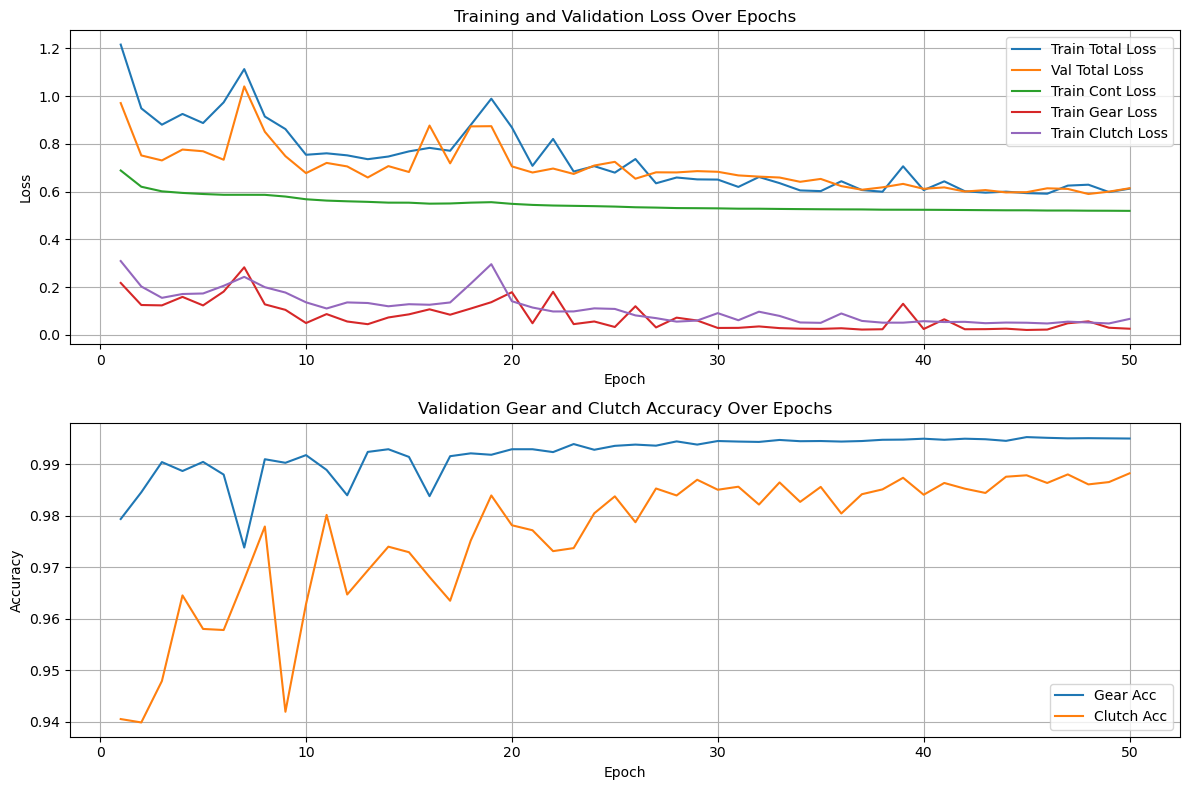

Training complete. Best model saved as 'best_model.pt'. Loss plot saved as 'loss_plot.png'.


C:\Users\HP\AppData\Local\Temp\ipykernel_5016\129851780.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


In [20]:
# Main execution
if __name__ == "__main__":
    # # Define columns
    # sensor_cols = ['Angle', 'CurrentLapTime', 'Damage', 'DistanceFromStart', 'DistanceCovered', 
    #                'FuelLevel', 'gear_drop', 'LastLapTime', 'RacePosition', 'RPM', 
    #                'SpeedX', 'SpeedY', 'SpeedZ', 'Track_1', 'Track_2', 'Track_3', 
    #                'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 
    #                'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 
    #                'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition', 
    #                'WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3', 
    #                'WheelSpinVelocity_4', 'Z']
    # continuous_cols = ['Acceleration', 'Braking', 'Steering']
    # discrete_cols = ['Gear', 'Clutch']
    
    # # Load datasets
    # train_dataset = TORCSDataset('../data_generation/data/dirt-2/train_data.csv', sensor_cols, continuous_cols, discrete_cols)
    # val_dataset = TORCSDataset('../data_generation/data/dirt-2/val_data.csv', sensor_cols, continuous_cols, discrete_cols)
    
    # train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    

    
    # Train and plot
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=50, device=device)
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))
    print("Training complete. Best model saved as 'best_model.pt'. Loss plot saved as 'loss_plot.png'.")

In [48]:
import pandas as pd

# Check train_data.csv
train_data = pd.read_csv('../data_generation/data/dirt-2/train_data.csv')
print("Train Gear unique values:", train_data['Gear'].unique())
print("Train Gear value counts:\n", train_data['Gear'].value_counts())
print("Train Clutch unique values:", train_data['Clutch'].unique())
print("Train Clutch value counts:\n", train_data['Clutch'].value_counts())

# Check val_data.csv
val_data = pd.read_csv('../data_generation/data/dirt-2/val_data.csv')
print("\nVal Gear unique values:", val_data['Gear'].unique())
print("Val Gear value counts:\n", val_data['Gear'].value_counts())
print("Val Clutch unique values:", val_data['Clutch'].unique())
print("Val Clutch value counts:\n", val_data['Clutch'].value_counts())

Train Gear unique values: [ 1  3  2 -1]
Train Gear value counts:
 Gear
 1    90333
 3    79053
 2    61333
-1      469
Name: count, dtype: int64
Train Clutch unique values: [0.  0.5]
Train Clutch value counts:
 Clutch
0.0    229502
0.5      1686
Name: count, dtype: int64

Val Gear unique values: [ 2  1 -1  3]
Val Gear value counts:
 Gear
 1    11502
 3     9741
 2     7593
-1       63
Name: count, dtype: int64
Val Clutch unique values: [0.  0.5]
Val Clutch value counts:
 Clutch
0.0    28657
0.5      242
Name: count, dtype: int64
